In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from tslearn.utils import to_time_series_dataset

Using TensorFlow backend.


In [3]:
from ipynb.fs.defs.BOPF import BOPF_fit, BOPF_predict

In [4]:
def DTWDistance(s1, s2, w = None):
    rows = len(s1) + 1
    cols = len(s2) + 1
    DTW = np.zeros((rows, cols))
    
    if w:
        w = max(w, abs(len(s1)-len(s2)))
        
        for i in range(0, rows):
            for j in range(0, cols):
                DTW[i, j] = float('inf')
        
        DTW[0, 0] = 0
        
        for i in range(1, rows):
            for j in range(max(1, i-w), min(cols, i+w+1)):
                DTW[i, j] = 0
        
        distance = 0
        
        for i in range(1, rows):
            for j in range(max(1, i-w), min(cols, i+w+1)):
                distance = (s1[i-1] - s2[j-1]) ** 2
                DTW[i,j] = distance + min(DTW[i-1,j], DTW[i-1,j-1], DTW[i, j-1])
    return DTW[len(s1), len(s2)]

In [5]:
valori_ts = []
classi = []

path = ""

# calcoliamo le features di ogni timeseries

with open(path + 'UrbanObservatory.meta.csv', 'r', encoding='utf-8') as dati:
    for row in dati:
        riga = row.strip().split(',')
        classe = int(riga[8])
        classi.append(classe)
        valori = np.array(riga[9:]).astype(np.float)
        valori_ts.append(valori)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(valori_ts, classi, test_size = 0.3, random_state = 100)

In [7]:
from sklearn.preprocessing import RobustScaler

X_train_norm = RobustScaler().fit_transform(X_train)
X_test_norm = RobustScaler().fit_transform(X_test)

In [8]:
# calcola accuracy e f1 score di un classificatore

def metrics(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)*100
    f1 = f1_score(y_test, y_pred, average = 'macro')*100
    return [accuracy, f1]

In [9]:
metrics_standard = []
metrics_norm = []

In [10]:
# 1NN-ED

knn = KNeighborsClassifier(n_neighbors = 1, metric = 'euclidean')
knn.fit(X_train, y_train)
metrics_standard.append(metrics(knn, X_test, y_test))

knn.fit(X_train_norm, y_train)
metrics_norm.append(metrics(knn, X_test_norm, y_test))

In [ ]:
# 1NN-DTW (testare diversi parametri w)

knn = KNeighborsClassifier(n_neighbors = 1, metric = DTWDistance, metric_params = {'w': len(valori_ts[0])})
knn.fit(X_train, y_train)
metrics_standard.append(metrics(knn, X_test, y_test))

knn.fit(X_train_norm, y_train)
metrics_norm.append(metrics(knn, X_test_norm, y_test))

In [ ]:
# per usare il dataset nella libreria tslearn dobbiamo convertirlo con la seguente funzione

X_train_tslearn = to_time_series_dataset(X_train)
X_test_tslearn = to_time_series_dataset(X_test)

X_train_tslearn_norm = to_time_series_dataset(X_train_norm)
X_test_tslearn_norm = to_time_series_dataset(X_test_norm)

# calcolo shapelet_sizes

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=len(valori_ts), ts_sz=len(valori_ts[0]),
                                                       n_classes=len(set(classi)), l=0.1, r=2)

In [ ]:
# shapelet-based classifier

shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes, verbose_level = 0, max_iter = 5000)
shp_clf.fit(np.array(X_train_tslearn), np.array(y_train))
metrics_standard.append(metrics(shp_clf, np.array(X_test_tslearn), np.array(y_test)))

shp_clf.fit(np.array(X_train_tslearn_norm), np.array(y_train))
metrics_norm.append(metrics(shp_clf, np.array(X_test_tslearn_norm), np.array(y_test)))

In [ ]:
metrics_standard.append([74.6875, 0.0])

In [ ]:
metrics_norm.append([75.3125, 0.0])

In [ ]:
# bag of pattern features

# leggo il dataset - per questo classificatore occorre un dataframe pandas

dataframe = pd.read_csv('Swissex.meta.csv', header = None, sep = ',')
dataframe = dataframe.drop(np.arange(0,8), axis=1)

# split del dataset
X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(8, axis = 1), dataframe[8], test_size = 0.3, random_state = 100)
X_train_norm = RobustScaler().fit_transform(X_train)
X_test_norm = RobustScaler().fit_transform(X_test)

X_train_norm = pd.DataFrame(X_train_norm, columns= [column for column in dataframe.drop(8, axis = 1)])
X_test_norm = pd.DataFrame(X_test_norm, columns= [column for column in dataframe.drop(8, axis = 1)])
X_train[8] = y_train
X_train_norm[8] = y_train

predictors = BOPF_fit(X_train, y_train)
y_pred = BOPF_predict(predictors, X_test)
metrics_standard.append([accuracy_score(y_test, y_pred)*100, f1_score(y_test, y_pred, average = 'macro')*100])

predictors = BOPF_fit(X_train_norm, y_train)
y_pred_norm = BOPF_predict(predictors, X_test_norm)
metrics_norm.append([accuracy_score(y_test, y_pred_norm)*100, f1_score(y_test, y_pred_norm, average = 'macro')*100])

In [17]:
metrics_standard = [[55.769230769230774, 50.28156326069039],
 [74.03846153846155, 73.01337668628018],
 [22.115384615384613, 5.081585081585082],
 [25.0, 21.284893449116325]]
metrics_norm = [[47.11538461538461, 44.190030244291215],
 [44.230769230769226, 39.549552875768214],
 [7.6923076923076925, 1.3852813852813854],
 [9.615384615384617, 3.7754948202709393]]

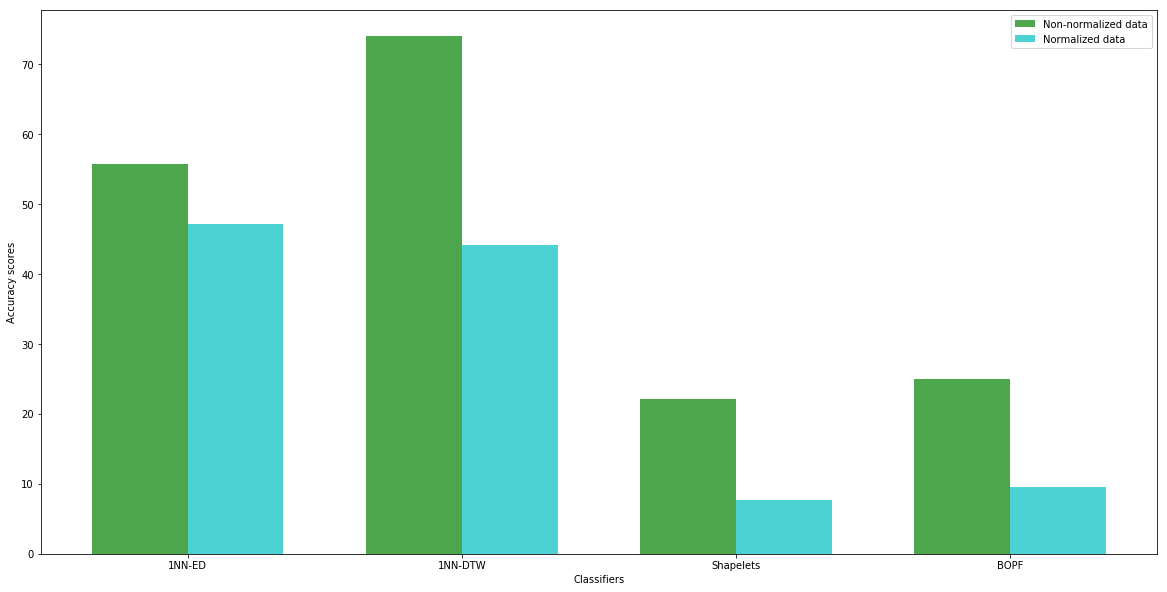

In [18]:
# plottiamo le accuracy a confronto

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
n_groups = 4
index = np.arange(n_groups)
bar_width = 0.35

opacity = .7
error_config = {'ecolor': '0.3'}

standard_clf = ax.bar(index, [y[0] for y in metrics_standard], bar_width, alpha=opacity, color='g', error_kw=error_config, label='Non-normalized data')
normalized_clf = ax.bar(index + bar_width, [y[0] for y in metrics_norm], bar_width, alpha=opacity, color='c', error_kw=error_config, label='Normalized data')
labels = ['1NN-ED', '1NN-DTW', 'Shapelets', 'BOPF']

ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((labels))
ax.legend()

plt.show()


In [21]:
from shapelets_lts.classification import LtsShapeletClassifier

In [22]:
classifier = LtsShapeletClassifier(
    K=20,
    R=3,
    L_min=30,
    epocs=50,
    lamda=0.01,
    eta=0.01,
    shapelet_initialization='segments_centroids'
)

In [25]:
classifier.fit(np.array(X_train_norm), np.array(y_train))

Network initialization ...
Using training data to initialize shaplets
Training ...
epoch=1/50 (iteration=242) loss=nan validation accuracy=0.045454545454545456
epoch=2/50 (iteration=484) loss=nan validation accuracy=0.045454545454545456
epoch=3/50 (iteration=726) loss=nan validation accuracy=0.045454545454545456
epoch=4/50 (iteration=968) loss=nan validation accuracy=0.045454545454545456
epoch=5/50 (iteration=1210) loss=nan validation accuracy=0.045454545454545456
epoch=6/50 (iteration=1452) loss=nan validation accuracy=0.045454545454545456
epoch=7/50 (iteration=1694) loss=nan validation accuracy=0.045454545454545456
epoch=8/50 (iteration=1936) loss=nan validation accuracy=0.045454545454545456
epoch=9/50 (iteration=2178) loss=nan validation accuracy=0.045454545454545456
epoch=10/50 (iteration=2420) loss=nan validation accuracy=0.045454545454545456
epoch=11/50 (iteration=2662) loss=nan validation accuracy=0.045454545454545456
epoch=12/50 (iteration=2904) loss=nan validation accuracy=0.0

LtsShapeletClassifier(K=20, L_min=30, R=3, alpha=-100, epocs=50, eta=0.01,
                      lamda=0.01, plot_loss=False,
                      shapelet_initialization='segments_centroids')

In [27]:
y_pred = classifier.predict(np.array(X_test))

In [28]:
accuracy = accuracy_score(y_test, y_pred)*100
accuracy

4.807692307692308